# Datenanalyse von Mess- und Flächennutzungsdaten             <img src="https://www.btelligent.com/fileadmin/_processed_/7/0/csm_data-science-ansatz_2350412d17.jpg" style="max-width:20%">


Zunächst importieren wir wieder die nötigen Pakete, definieren unseren Pfad (bzw. den Dateinnamen wenn im selben Ordner) und laden die CSV-Datei als Pandas-Dataframe.

In [92]:
import pandas as pd
import numpy as np

path = "your_qgis_output.csv"

data = pd.read_csv(path, sep = ",")
print(data.head())

   distance  Concentrat join_strassenklassen_strassenkl  \
0      50.0      6881.5                             III   
1     150.0      7169.5                             III   
2     250.0      6451.5                             III   
3     350.0      6901.5                             III   
4     450.0      5906.0                             III   

   Joined layer_traff_norm_mean  
0                      0.120633  
1                      0.127050  
2                      0.131300  
3                      0.131300  
4                      0.125500  


## Long data format        <img src="https://www.joyofdata.de/blog/wp-content/uploads/2012/11/Clipboard16.png" style="max-width:100%">


Die Daten befinden sich momentan noch im sogenannten long data format. Wir werden sie in diesem weiterverarbeiten und anschließend in das wide data format umwandeln. Zum Unterschieden [hier](https://www.theanalysisfactor.com/wide-and-long-data/) noch eine kurze Erläuterung.
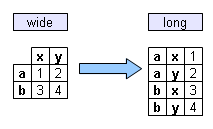

Zunächst benennen wir die Spalten neu, um Missverständnisse zu vermeiden. **Solltet ihr von meiner Reihenfolge und Benennung abgewichen sein, passt die Benennung hier bitte an.**

In [93]:
data.columns = ['trackpoint', 'ufp', 'street_class', 'traffic_norm']
print(data.head())

   trackpoint     ufp street_class  traffic_norm
0        50.0  6881.5          III      0.120633
1       150.0  7169.5          III      0.127050
2       250.0  6451.5          III      0.131300
3       350.0  6901.5          III      0.131300
4       450.0  5906.0          III      0.125500


# Analysen            <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Scikit_learn_logo_small.svg/200px-Scikit_learn_logo_small.svg.png" style="max-width:100%">
In diesem Dataframe liegen nun alle Informationen vor, wie wir sie brauchen. Wir können also damit beginnen den Datensatz näher zu analysieren und Hypothesen zu untersuchen. Die folgenden Zeilen zeigen euch, wie ihr in Python mit den Paketen `scikit-learn` und `matplotlib` eine Regression durchführt. Ihr könnt hier aber auch bereits gelerntes aus der letzten Sitzung anwenden und den Datensatz auf weitere Hypothesen untersuchen.
Zunächst schauen wir uns einen linearen Zusammenhang zwischen metrischen Daten an.

**Beachte:** *Es handelt sich hier nicht um einen aufgehübschten Beispieldatensatz sondern um echte Messdaten, wie sie viele von euch auch erhalten werden. Wenn eure Plots also nicht aussehen wie aus dem Lehrbuch und auch die Statistiken eher enttäuschen seid ihr vermutlich auf dem richtigen Weg ;)*

## Lineare Regression

In [94]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

Ein Blick auf die Spaltennamen gibt uns einen Überblick, welche Variablen wir miteinander vergleichen können.

In [95]:
print(data.columns.values)

['trackpoint' 'ufp' 'street_class' 'traffic_norm']


Der gemessene Ultrafeinstaubwert (`'ufp'`) wird also jeweils unsere abhängige Variable (oder "Predictand", `Y`) sein, das Verkehrsaufkommen oder dei Straßenklasse jeweils die unabhängige Variable (oder "Predictor", `X`). Da wir verschiedene Variablen betrachten wollen, schaffen wir hierfür eine separate Variable (`predictor`) und müssen im Anschluss noch nur diese ändern, um uns weitere Analysen ausgeben zu lassen. Wir beginnen mit dem Verkehrsaufkommen.

Der Datensatz enthält noch ziemlich viele NaN, da wir ja nur für knapp die Hälfte der Messpunkte Verkehrsdaten haben. Für die Regression müssen wir diese Werte entfernen.

Zunächst nutzen wir Boolean Indexing, um alle Zeilen zu markieren, in denen es keine UFP-Daten gibt (also wo `isna() = True` gilt).

In [96]:
where_nan = data['ufp'].isna()
print(where_nan)

0      False
1      False
2      False
3      False
4      False
       ...  
449    False
450    False
451    False
452    False
453    False
Name: ufp, Length: 454, dtype: bool


Nun erstellen wir ein Subset der Datentabelle, in der alle Zeilen Verkehrsdaten haben. Die `~` kehrt den Boolean Index dabei um: `NaN = False`. Da wir die vollständigen Daten nicht mehr brauchen überschreiben wir die Originaltabelle mit dem Subset (*von 454 auf 436 Zeilen*).

In [97]:
data = data[~where_nan]
print(data)

     trackpoint      ufp street_class  traffic_norm
0          50.0   6881.5          III      0.120633
1         150.0   7169.5          III      0.127050
2         250.0   6451.5          III      0.131300
3         350.0   6901.5          III      0.131300
4         450.0   5906.0          III      0.125500
..          ...      ...          ...           ...
449     45050.0   7275.0          III      0.114100
450     45150.0   6101.0            V      0.124833
451     45250.0  17187.0          III      0.132300
452     45350.0  28066.0          III      0.127050
453     45450.0   7064.0          III      0.127050

[436 rows x 4 columns]


Für die Regressionsanalyse beginnen wir zunächst mit dem Verkehrsaufkommen.

In [98]:
predictor = 'traffic_norm'

Dafür filtern wir alle Zeilen, in denen es keine Verkehrsdaten gibt (*von 436 auf 211 Zeilen!*).

**Beachte:** *Im Gegensatz zu den Flächenanteilen dürfen wir die Werte nicht 0 setzen! Dies würde bedeuten wir gehen überall, wo es keine Zählungen gab von keinem Verkehr aus, was die Regression massiv verfälschen würde.*

In [99]:
traffic_subset = data[~data['traffic_norm'].isna()]
print(traffic_subset)

     trackpoint      ufp street_class  traffic_norm
0          50.0   6881.5          III      0.120633
1         150.0   7169.5          III      0.127050
2         250.0   6451.5          III      0.131300
3         350.0   6901.5          III      0.131300
4         450.0   5906.0          III      0.125500
..          ...      ...          ...           ...
449     45050.0   7275.0          III      0.114100
450     45150.0   6101.0            V      0.124833
451     45250.0  17187.0          III      0.132300
452     45350.0  28066.0          III      0.127050
453     45450.0   7064.0          III      0.127050

[211 rows x 4 columns]


Für die Regression-Funktionen müssen wir die zu untersuchenden Spalten in NumPy-Arrays umwandeln.

In [100]:
X = traffic_subset.loc[:, predictor].values.reshape(-1, 1)
Y = traffic_subset.loc[:, 'ufp'].values.reshape(-1, 1)

Im nächsten Schritt instanzieren wir die Datenklasse `LinearRegression`.

In [101]:
linear_regressor = LinearRegression()

Nun trainieren wir unsere lineare Regression (`.fit`) und speichern alle Informationen über unseren Regressor (oder "Predictor") in der Variable `Y_pred`.

In [102]:
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

Zunächst lassen wir uns das Ergebnis in einem Scatterplot mit der Regressionsgeraden anzeigen. Vereinfacht kann man sagen, die Regressionsgerade beschreibt die lineare Funktion (`Y = a*X + b`), mit der sich die Ultrafeinstaubkonzentration mittels des mittleren Verkehrsaufkommens im Umkreis von 100m um den Messpunkt vorhersagen lässt.

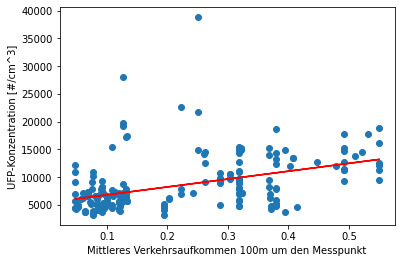

In [103]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel(str('Mittleres Verkehrsaufkommen' + ' 100m um den Messpunkt'))
plt.ylabel('UFP-Konzentration [#/cm^3]')
plt.show()

Der Plot gibt uns eine Ahnung von der Verteilung der Messwerte und der Richtung und Stärke des Zusammenhangs. Wir erhalten aber keine Informationen über die Güte des linearen Modells. Darum lassen wir uns die `Funktion` des Modells und den Wert `R²` ausgeben. Letzterer gibt uns ein Maß für die Stärke des Zusammenhangs von X und Y.

In [104]:
print('------ Lineare Regression -----')
print('Funktion: y = %.3f * x + %.3f' % (linear_regressor.coef_[0], linear_regressor.intercept_))
print("R² Score: {:.2f}".format(linear_regressor.score(X, Y)))
print("\n")

------ Lineare Regression -----
Funktion: y = 14184.115 * x + 5415.667
R² Score: 0.19




Was sehen wir hier? Die Korrelation der Größen ist gering aber vorhanden. Probieren wir es mit einem weiteren Datensatz.

## Lineare Regression mit ordinalen Prädiktoren

Da die Straßenklassen ordinalskalierte Daten sind müssen wir hier mit entsprechenden Funktionen vorgehen.

In [105]:
from sklearn.preprocessing import OneHotEncoder

predictor = 'street_class'
where_nan = data[predictor].isna()

print(data[where_nan])

     trackpoint     ufp street_class  traffic_norm
21       2150.0  5218.5          NaN           NaN
22       2250.0  5254.0          NaN           NaN
23       2350.0  5080.0          NaN           NaN
25       2550.0  4661.0          NaN           NaN
26       2650.0  4751.0          NaN           NaN
27       2750.0  4734.5          NaN           NaN
28       2850.0  4782.0          NaN           NaN
29       2950.0  4965.0          NaN           NaN
30       3050.0  5044.5          NaN           NaN
31       3150.0  5245.0          NaN           NaN
32       3350.0  4303.5          NaN           NaN
33       3450.0  4209.0          NaN           NaN
34       3550.0  4279.0          NaN           NaN
35       3650.0  4272.0          NaN           NaN
37       3850.0  3727.0          NaN           NaN
38       3950.0  3744.0          NaN           NaN
40       4150.0  3680.0          NaN           NaN
41       4250.0  3594.0          NaN           NaN
42       4350.0  3438.0        

In [106]:
data[predictor].fillna('No_street', inplace=True)

print(data[where_nan])


     trackpoint     ufp street_class  traffic_norm
21       2150.0  5218.5    No_street           NaN
22       2250.0  5254.0    No_street           NaN
23       2350.0  5080.0    No_street           NaN
25       2550.0  4661.0    No_street           NaN
26       2650.0  4751.0    No_street           NaN
27       2750.0  4734.5    No_street           NaN
28       2850.0  4782.0    No_street           NaN
29       2950.0  4965.0    No_street           NaN
30       3050.0  5044.5    No_street           NaN
31       3150.0  5245.0    No_street           NaN
32       3350.0  4303.5    No_street           NaN
33       3450.0  4209.0    No_street           NaN
34       3550.0  4279.0    No_street           NaN
35       3650.0  4272.0    No_street           NaN
37       3850.0  3727.0    No_street           NaN
38       3950.0  3744.0    No_street           NaN
40       4150.0  3680.0    No_street           NaN
41       4250.0  3594.0    No_street           NaN
42       4350.0  3438.0    No_s

In [107]:
X = data.loc[:, predictor].values.reshape(-1, 1)
Y = data.loc[:, 'ufp'].values.reshape(-1, 1)

In [112]:
enc = OneHotEncoder(sparse=False)
X_trans = enc.fit_transform(X)

linear_regressor = LinearRegression(fit_intercept=False)
linear_regressor.fit(X_trans, Y)

print("Mean squared error: %.2f" % np.mean((linear_regressor.predict(X_trans) - Y) ** 2))

print(linear_regressor.coef_[0])
print(linear_regressor.intercept_)

Mean squared error: 10800103.81
[12236.35       10221.22560976  7256.74427481  7133.42857143
  4568.76315789  4849.0515873 ]
0.0


In [116]:
print(data.iloc[:, :-1])
print(data.iloc[:, :])


     trackpoint      ufp street_class
0          50.0   6881.5          III
1         150.0   7169.5          III
2         250.0   6451.5          III
3         350.0   6901.5          III
4         450.0   5906.0          III
..          ...      ...          ...
449     45050.0   7275.0          III
450     45150.0   6101.0            V
451     45250.0  17187.0          III
452     45350.0  28066.0          III
453     45450.0   7064.0          III

[436 rows x 3 columns]
     trackpoint      ufp street_class  traffic_norm
0          50.0   6881.5          III      0.120633
1         150.0   7169.5          III      0.127050
2         250.0   6451.5          III      0.131300
3         350.0   6901.5          III      0.131300
4         450.0   5906.0          III      0.125500
..          ...      ...          ...           ...
449     45050.0   7275.0          III      0.114100
450     45150.0   6101.0            V      0.124833
451     45250.0  17187.0          III      0.132300


In [113]:
print('------ Lineare Regression -----')
# print('Funktion: y = %.3f * x + %.3f' % (linear_regressor.coef_[0], linear_regressor.intercept_))
print("R² Score: {:.2f}".format(linear_regressor.score(X, Y)))
print("\n")



------ Lineare Regression -----


ValueError: could not convert string to float: 'III'

In [ ]:
# Kendalls tau und pearson zuerst, dann Regression
# Normalverteilung? --> Bedingungen für lineare Regression checken!?
# UFP auch in Klassen einteilen um Verteilung rauszubekommen


